<a href="https://colab.research.google.com/github/abhirupchak/Computer-Science/blob/main/Data_Mining_All_In_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn mlxtend seaborn openpyxl

In [ ]:
"""
Simplified Data Mining Practicals - All 6 Questions
For Undergraduate Data Mining Course
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("DATA MINING PRACTICALS")
print("="*70)

# ============================================================================
# QUESTION 1: DATA CLEANING
# ============================================================================
print("\n" + "="*70)
print("QUESTION 1: DATA CLEANING")
print("="*70)

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=';')

print("\n1.1 Original Dataset:")
print(f"Shape: {wine_data.shape}")
print(wine_data.head())

# Create a copy and introduce missing values for demonstration
wine_clean = wine_data.copy()
np.random.seed(42)
for col in ['fixed acidity', 'volatile acidity', 'citric acid']:
    missing_idx = np.random.choice(wine_clean.index, size=15, replace=False)
    wine_clean.loc[missing_idx, col] = np.nan

# 1.2 Handling Missing Values
print("\n1.2 Handling Missing Values:")
print("Missing values before:")
print(wine_clean.isnull().sum())

# Fill with mean
for col in wine_clean.columns:
    if wine_clean[col].isnull().sum() > 0:
        wine_clean[col].fillna(wine_clean[col].mean(), inplace=True)

print("\nMissing values after filling with mean:")
print(wine_clean.isnull().sum())

# 1.3 Handling Outliers (IQR method)
print("\n1.3 Handling Outliers (IQR Method):")
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[column] < lower) | (df[column] > upper)).sum()
    print(f"{column}: {outliers} outliers (Range: {lower:.2f} to {upper:.2f})")
    df[column] = df[column].clip(lower=lower, upper=upper)
    return df

for col in ['fixed acidity', 'volatile acidity']:
    wine_clean = handle_outliers(wine_clean, col)

# 1.4 Handling Inconsistent Values
print("\n1.4 Handling Inconsistent Values:")
print(f"Duplicate rows: {wine_clean.duplicated().sum()}")
wine_clean = wine_clean.drop_duplicates()
print(f"Shape after cleaning: {wine_clean.shape}")

# ============================================================================
# QUESTION 2: DATA PRE-PROCESSING
# ============================================================================
print("\n" + "="*70)
print("QUESTION 2: DATA PRE-PROCESSING")
print("="*70)

# Load Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

print("\n2.1 Original Data:")
print(iris_df.head())

# 2.2 Standardization
print("\n2.2 Standardization (Mean=0, Std=1):")
scaler_std = StandardScaler()
iris_std = scaler_std.fit_transform(iris_df.iloc[:, :-1])
print(f"Mean after standardization: {iris_std.mean(axis=0)}")
print(f"Std after standardization: {iris_std.std(axis=0)}")

# 2.3 Normalization
print("\n2.3 Normalization (Min-Max to [0,1]):")
scaler_mm = MinMaxScaler()
iris_norm = scaler_mm.fit_transform(iris_df.iloc[:, :-1])
print(f"Min after normalization: {iris_norm.min(axis=0)}")
print(f"Max after normalization: {iris_norm.max(axis=0)}")

# 2.4 Transformation
print("\n2.4 Log Transformation:")
iris_log = np.log1p(iris_df.iloc[:, :-1])
print(iris_log.head())

# 2.5 Aggregation
print("\n2.5 Aggregation (Group by species):")
agg_result = iris_df.groupby('target')['sepal length (cm)'].agg(['mean', 'std'])
print(agg_result)

# 2.6 Discretization (Binning)
print("\n2.6 Discretization:")
iris_df['sepal_binned'] = pd.cut(iris_df['sepal length (cm)'],
                                  bins=3, labels=['Low', 'Medium', 'High'])
print(iris_df['sepal_binned'].value_counts())

# 2.7 Binarization
print("\n2.7 Binarization:")
median_val = iris_df['sepal length (cm)'].median()
iris_df['sepal_binary'] = (iris_df['sepal length (cm)'] > median_val).astype(int)
print(iris_df['sepal_binary'].value_counts())

# 2.8 Sampling
print("\n2.8 Sampling:")
sample = iris_df.sample(n=50, random_state=42)
print(f"Random sample size: {sample.shape}")

# ============================================================================
# QUESTION 3: APRIORI ALGORITHM
# ============================================================================
print("\n" + "="*70)
print("QUESTION 3: APRIORI ALGORITHM")
print("="*70)

# Create market basket dataset
transactions = [
    ['Milk', 'Bread', 'Butter'],
    ['Bread', 'Butter'],
    ['Milk', 'Bread', 'Butter', 'Cheese'],
    ['Milk', 'Bread', 'Cheese'],
    ['Bread', 'Butter', 'Cheese'],
    ['Milk', 'Butter'],
    ['Milk', 'Bread', 'Butter', 'Cheese'],
    ['Bread', 'Butter'],
    ['Milk', 'Bread', 'Cheese'],
    ['Milk', 'Bread', 'Butter']
]

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_array, columns=te.columns_)

print("\n3.1 Transaction Data:")
print(basket_df)

# Case (a): support=50%, confidence=75%
print("\n3.2 Case (a): min_support=50%, min_confidence=75%")
freq_items_a = apriori(basket_df, min_support=0.5, use_colnames=True)
print("\nFrequent Itemsets:")
print(freq_items_a)

rules_a = association_rules(freq_items_a, metric="confidence", min_threshold=0.75)
if len(rules_a) > 0:
    print("\nAssociation Rules:")
    print(rules_a[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("No rules found")

# Case (b): support=60%, confidence=60%
print("\n3.3 Case (b): min_support=60%, min_confidence=60%")
freq_items_b = apriori(basket_df, min_support=0.6, use_colnames=True)
print("\nFrequent Itemsets:")
print(freq_items_b)

rules_b = association_rules(freq_items_b, metric="confidence", min_threshold=0.6)
if len(rules_b) > 0:
    print("\nAssociation Rules:")
    print(rules_b[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
    print("No rules found")

# ============================================================================
# QUESTION 4: CLASSIFICATION
# ============================================================================
print("\n" + "="*70)
print("QUESTION 4: CLASSIFICATION ALGORITHMS")
print("="*70)

# Prepare datasets
# Dataset 1: Wine Quality (Binary classification)
X_wine = wine_clean.iloc[:, :-1].values
y_wine = (wine_clean.iloc[:, -1] >= 6).astype(int)  # Good(1) vs Bad(0)

# Dataset 2: Iris
X_iris = iris_std
y_iris = iris_df['target'].values

# Classifiers
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)

classifiers = {'Naive Bayes': nb, 'KNN': knn, 'Decision Tree': dt}

def evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

# Test on Wine dataset
print("\n4.1 Dataset: Wine Quality")

# Holdout 80-20
print("\n  Holdout Method (80-20):")
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine,
                                                      test_size=0.2, random_state=42)
for name, clf in classifiers.items():
    metrics = evaluate(clf, X_train, X_test, y_train, y_test)
    print(f"  {name}: Acc={metrics['Accuracy']:.3f}, Prec={metrics['Precision']:.3f}, "
          f"Rec={metrics['Recall']:.3f}, F1={metrics['F1-Score']:.3f}")

# Holdout 66-33
print("\n  Holdout Method (66-33):")
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine,
                                                      test_size=0.33, random_state=42)
for name, clf in classifiers.items():
    metrics = evaluate(clf, X_train, X_test, y_train, y_test)
    print(f"  {name}: Acc={metrics['Accuracy']:.3f}, Prec={metrics['Precision']:.3f}, "
          f"Rec={metrics['Recall']:.3f}, F1={metrics['F1-Score']:.3f}")

# 10-fold CV
print("\n  10-Fold Cross-Validation:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_wine, y_wine, cv=10, scoring='accuracy')
    print(f"  {name}: Accuracy={scores.mean():.3f} (+/- {scores.std():.3f})")

# 5-fold CV
print("\n  5-Fold Cross-Validation:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_wine, y_wine, cv=5, scoring='accuracy')
    print(f"  {name}: Accuracy={scores.mean():.3f} (+/- {scores.std():.3f})")

# Test on Iris dataset
print("\n4.2 Dataset: Iris")

# Holdout 80-20
print("\n  Holdout Method (80-20):")
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris,
                                                      test_size=0.2, random_state=42)
for name, clf in classifiers.items():
    metrics = evaluate(clf, X_train, X_test, y_train, y_test)
    print(f"  {name}: Acc={metrics['Accuracy']:.3f}, Prec={metrics['Precision']:.3f}, "
          f"Rec={metrics['Recall']:.3f}, F1={metrics['F1-Score']:.3f}")

# 10-fold CV
print("\n  10-Fold Cross-Validation:")
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_iris, y_iris, cv=10, scoring='accuracy')
    print(f"  {name}: Accuracy={scores.mean():.3f} (+/- {scores.std():.3f})")

# ============================================================================
# QUESTION 5: K-MEANS CLUSTERING
# ============================================================================
print("\n" + "="*70)
print("QUESTION 5: K-MEANS CLUSTERING")
print("="*70)

X_cluster = iris_std

# Try different K values
print("\n5.1 Comparing different K values:")
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    print(f"K={k}: MSE={kmeans.inertia_:.2f}, "
          f"Silhouette={silhouette_score(X_cluster, labels):.3f}")

# Plot MSE vs iterations for K=3
print("\n5.2 Plotting MSE vs Iterations (K=3):")
mse_values = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=3, max_iter=i, n_init=1, random_state=42)
    kmeans.fit(X_cluster)
    mse_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), mse_values, marker='o', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('MSE (Inertia)')
plt.title('K-Means: MSE vs Iterations (K=3)')
plt.grid(True, alpha=0.3)
plt.savefig('kmeans_mse.png', dpi=150, bbox_inches='tight')
print("  Plot saved as 'kmeans_mse.png'")
plt.close()


# ============================================================================
# QUESTION 6: DBSCAN CLUSTERING
# ============================================================================
print("\n" + "="*70)
print("QUESTION 6: DENSITY-BASED CLUSTERING (DBSCAN)")
print("="*70)

print("\n6.1 Testing different parameter combinations:")

results = []
for eps in [0.3, 0.5, 0.7, 1.0]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_cluster)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"\neps={eps}, min_samples={min_samples}:")
        print(f"  Clusters: {n_clusters}, Noise points: {n_noise}")

        # Calculate silhouette only if valid
        if n_clusters > 1 and n_noise < len(labels):
            mask = labels != -1
            if mask.sum() > n_clusters:
                sil = silhouette_score(X_cluster[mask], labels[mask])
                print(f"  Silhouette: {sil:.3f}")
                results.append((eps, min_samples, sil, n_clusters))

# Find best parameters
if results:
    best = max(results, key=lambda x: x[2])
    print(f"\n6.2 Best Parameters:")
    print(f"  eps={best[0]}, min_samples={best[1]}")
    print(f"  Silhouette Score: {best[2]:.3f}")
    print(f"  Number of clusters: {best[3]}")

    # Visualize best clustering
    dbscan = DBSCAN(eps=best[0], min_samples=best[1])
    labels = dbscan.fit_predict(X_cluster)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'DBSCAN (eps={best[0]}, min_samples={best[1]})')
    plt.colorbar(label='Cluster')

    plt.subplot(1, 2, 2)
    plt.scatter(X_cluster[:, 2], X_cluster[:, 3], c=labels, cmap='viridis')
    plt.xlabel('Feature 3')
    plt.ylabel('Feature 4')
    plt.title('DBSCAN (Different Features)')
    plt.colorbar(label='Cluster')

    plt.tight_layout()
    plt.savefig('dbscan_clusters.png', dpi=150, bbox_inches='tight')
    print("\n  Visualization saved as 'dbscan_clusters.png'")
    plt.close()

print("\n" + "="*70)
print("ALL PRACTICALS COMPLETED!")
print("="*70)
print("\nGenerated Files:")
print("  1. kmeans_mse.png")
print("  2. kmeans_elbow.png")
print("  3. dbscan_clusters.png")
print("="*70)

DATA MINING PRACTICALS

QUESTION 1: DATA CLEANING

1.1 Original Dataset:
Shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56

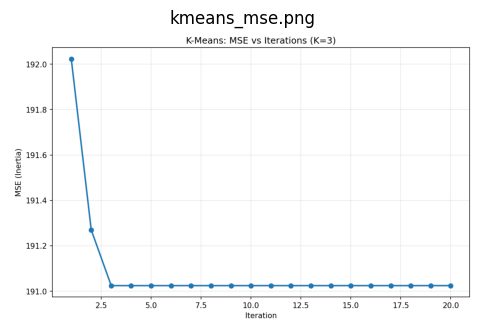

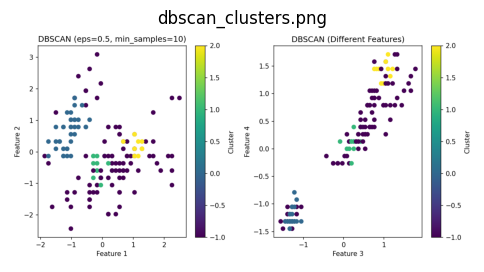

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for file in ["kmeans_mse.png", "dbscan_clusters.png"]:
    img = mpimg.imread(file)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(file)
    plt.show()
